# Collection 3 for Menindee

This is the second check of the new collection, this time focussed on Menindee lakes (rather than Tasmania).

## Preliminaries: load the data

In [1]:
import datacube, numpy as np, pandas, matplotlib.pyplot as plt, dask.distributed, xarray

In [2]:
client = dask.distributed.Client('127.0.0.1:11311')

In [3]:
def fuser(a, b):
    """For mosaicing WOFLs"""
    nota = (a & 1).astype(np.bool)
    notb = (b & 1).astype(np.bool)
    both = ~(nota | notb)
    output = a
    output[both] |= b[both]
    output[nota] = b[nota]
    return output

In [4]:
# Menindee lakes
lat, lon = -32.4, 142.4
e = 0.2
spatial = dict(lat=(lat-e,lat+e), lon=(lon-e,lon+e))

In [5]:
dc = datacube.Datacube()

'ga_ls_wofs_3',
 'sentinel2_wofs_nrt',
 'wofs_albers',
 'wofs_annual_summary',
 'wofs_apr_oct_summary',
 'wofs_filtered_summary',
 'wofs_nov_mar_summary',
 'wofs_summary']

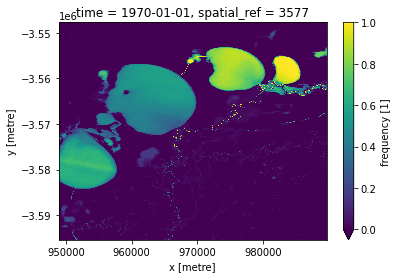

In [6]:
standard = dc.load(product='wofs_summary', **spatial)
standard.frequency.plot(vmax=1, vmin=0); None

In [7]:
new = dc.load(product='ga_ls_wofs_3', output_crs='epsg:3577', resolution=(-25,25),
              group_by='solar_day', fuse_func=fuser, dask_chunks={}, **spatial)

In [8]:
new.load()

<xarray.Dataset>
Dimensions:      (time: 981, x: 1634, y: 1906)
Coordinates:
  * time         (time) datetime64[ns] 1986-08-17T23:41:56.826013 ... 2020-07...
  * y            (y) float64 -3.548e+06 -3.548e+06 ... -3.595e+06 -3.595e+06
  * x            (x) float64 9.489e+05 9.489e+05 ... 9.897e+05 9.897e+05
    spatial_ref  int32 3577
Data variables:
    water        (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

In [9]:
old = dc.load(product='wofs_albers', output_crs='epsg:3577', resolution=(-25,25),
              group_by='solar_day', fuse_func=fuser, dask_chunks={}, **spatial)
old.load()

<xarray.Dataset>
Dimensions:      (time: 1770, x: 1634, y: 1906)
Coordinates:
  * time         (time) datetime64[ns] 1986-08-17T23:41:56.500000 ... 2020-08...
  * y            (y) float64 -3.548e+06 -3.548e+06 ... -3.595e+06 -3.595e+06
  * x            (x) float64 9.489e+05 9.489e+05 ... 9.897e+05 9.897e+05
    spatial_ref  int32 3577
Data variables:
    water        (time, y, x) int16 8 8 8 8 8 8 8 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

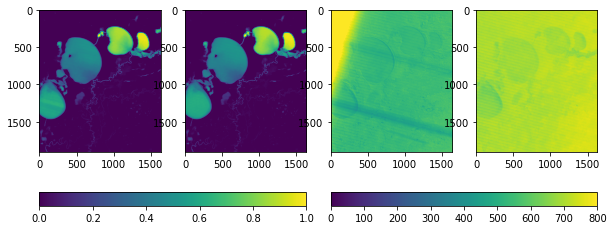

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
for ax, ax2, x in zip(axes[:2], axes[2:], [old.water, new.water]):
    wet = (x == 128).sum(axis=0)
    dry = (x == 0).sum(axis=0)
    clear = wet + dry
    freq = wet / clear
    p = ax.imshow(freq, vmin=0, vmax=1)
    p2 = ax2.imshow(clear, vmin=0, vmax=800)
plt.colorbar(p, ax=axes[:2], location='bottom');
plt.colorbar(p2, ax=axes[2:], location='bottom'); None

This shows that the overall summary is about the same, and the clear count seems to favour the new product (for most of this area).

## Matching individual layers
To ensure a fair comparison.

In [11]:
Old = old.copy(deep=False)
Old['time'] = (old.time + np.timedelta64(10, 'h')).to_pandas().dt.date.values.astype(np.datetime64)
New = new.copy(deep=False)
New['time'] = (new.time + np.timedelta64(10, 'h')).to_pandas().dt.date.values.astype(np.datetime64)

both = xarray.merge([Old.water.rename('old'), New.water.rename('new')], join='inner')

del old, new

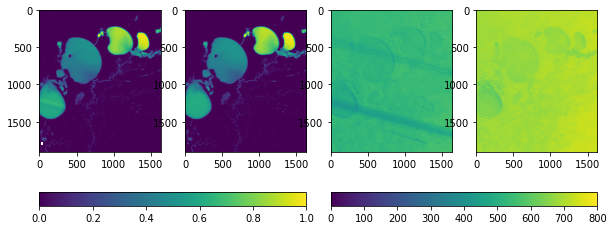

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
for ax, ax2, x in zip(axes[:2], axes[2:], [both.old, both.new]):
    wet = (x == 128).sum(axis=0)
    dry = (x == 0).sum(axis=0)
    clear = wet + dry
    freq = wet / clear
    p = ax.imshow(freq, vmin=0, vmax=1)
    p2 = ax2.imshow(clear, vmin=0, vmax=800)
plt.colorbar(p, ax=axes[:2], location='bottom');
plt.colorbar(p2, ax=axes[2:], location='bottom'); None

Now that the comparison is fair.. Note that the side-lapping pass has been excluded, presumably being unavailable in the new sample set.


In [13]:
oldwet = (both.old == 128).sum(axis=0)
oldclear = oldwet + (both.old == 0).sum(axis=0)
oldfreq = oldwet / oldclear
oldfreq2 = oldfreq.data.copy()
oldfreq2[oldfreq2 == 0] = np.nan

newwet = (both.new == 128).sum(axis=0)
newclear = newwet + (both.new == 0).sum(axis=0)
newfreq = newwet / newclear
newfreq2 = newfreq.data.copy()
newfreq2[newfreq2 == 0] = np.nan

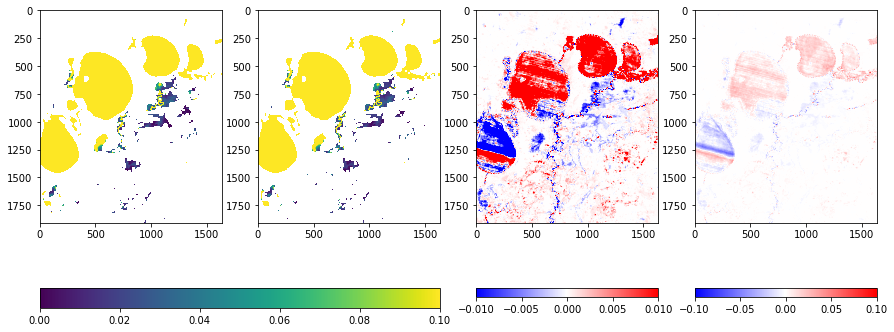

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(15, 8))
axes[0].imshow(oldfreq2, vmin=0, vmax=0.1)
p1 = axes[1].imshow(newfreq2, vmin=0, vmax=0.1)
p2 = axes[2].imshow(newfreq - oldfreq, vmin=-0.01, vmax=0.01, cmap='bwr')
p3 = axes[3].imshow(newfreq - oldfreq, vmin=-0.1, vmax=0.1, cmap='bwr')
plt.colorbar(p1, ax=axes[:2], location='bottom')
plt.colorbar(p2, ax=[axes[2]], location='bottom')
plt.colorbar(p3, ax=[axes[3]], location='bottom')
None

In [17]:
oldmask = (both.old.data & ~np.uint8(128)).astype(np.bool) # clear pixels
newmask = (both.new.data & ~np.uint8(128)).astype(np.bool)
oldmask.mean(), newmask.mean(), (oldmask & ~newmask).mean(), (newmask & ~oldmask).mean()

(0.4479439292919751,
 0.274642157131419,
 0.1844369383387539,
 0.011135166178197842)

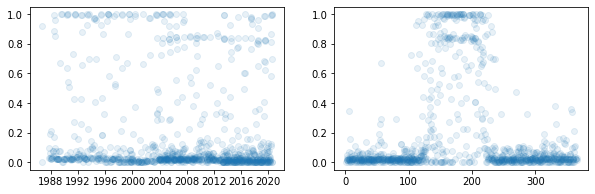

In [31]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1).scatter(both.time.data, (oldmask & ~newmask).mean(axis=(1,2)), alpha=0.1)
plt.subplot(1, 2, 2).scatter(both.time.to_pandas().dt.dayofyear, (oldmask & ~newmask).mean(axis=(1,2)), alpha=0.1)
None

Over Menindee, both versions look very similar. However, almost 20% of the data is masked in only the old version. This corresponds to winter.

In [23]:
sortofoldmask = (both.old.data & ~(np.uint8(128) | np.uint8(8))).astype(np.bool) # clear pixels ignoring old terrain masks
sortofoldmask.mean(), newmask.mean(), (sortofoldmask & ~newmask).mean(), (newmask & ~sortofoldmask).mean()

(0.2990203311532395,
 0.274642157131419,
 0.03788887922695226,
 0.013510705205131738)

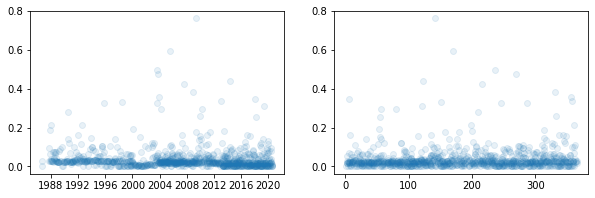

In [32]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1).scatter(both.time.data, (sortofoldmask & ~newmask).mean(axis=(1,2)), alpha=0.1)
plt.subplot(1, 2, 2).scatter(both.time.to_pandas().dt.dayofyear, (sortofoldmask & ~newmask).mean(axis=(1,2)), alpha=0.1)
None

In [38]:
mismatch = both.old.data[sortofoldmask & ~newmask] & ~np.uint8(8)

In [65]:
for i in range(8):
    m = (mismatch & 2**i).astype(np.bool).mean()
    print('%i \t %0.1f%% \t %i' % (i, m * 100, 2**i))

0 	 8.2% 	 1
1 	 48.4% 	 2
2 	 0.9% 	 4
3 	 0.0% 	 8
4 	 0.0% 	 16
5 	 10.3% 	 32
6 	 46.4% 	 64
7 	 18.6% 	 128


Ignoring the old terrain mask, there is no seasonal discrepancy. The remaining mismatch is mainly attributable to noncontiguous data and cloud extent.



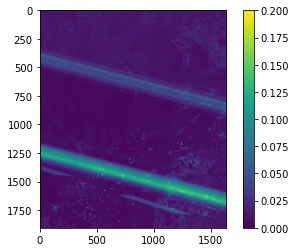

In [55]:
plt.imshow(((both.old.data & 2).astype(np.bool) & ~newmask).mean(axis=0), vmax=0.2)
plt.colorbar(); None

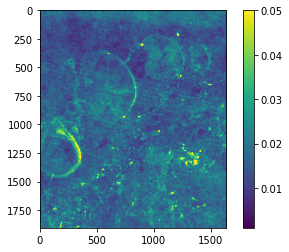

In [57]:
plt.imshow(((both.old.data & 64).astype(np.bool) & ~newmask).mean(axis=0), vmax=0.05)
plt.colorbar(); None

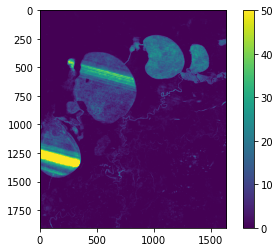

In [71]:
plt.imshow(((both.new.data == 128) & sortofoldmask).sum(axis=0), vmax=50)
plt.colorbar(); None

The data may actually be ok in these circumstances, in this region?